In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Financials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data

,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services
0,1993-05-04,444.05,99.760002,-2.967463,-4.945207,-4.945207382902539,144.300,131.300,176.600,141.200,155.800,157.8
1,1993-05-05,444.52,99.500000,-3.741880,-5.838931,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
2,1993-05-06,443.26,99.190002,-3.958573,-5.712923,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
3,1993-05-07,442.31,99.129997,-3.868640,-4.755962,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
4,1993-05-10,442.80,99.660004,-3.514697,-3.886583,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1656.619995,5.426902,15.653446,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7195,2021-11-26,4594.62,1612.869995,4.573863,14.003887,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7196,2021-11-29,4655.27,1639.089966,8.977288,18.674877,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7197,2021-11-30,4567.00,1615.829956,6.305224,16.089746,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1


## Using all data

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
0,1993,5,1993-05-13,439.23,99.300003,-4.763660,-6.391402,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.800,3
1,1993,6,1993-06-10,445.38,100.440002,-5.056491,-10.048363,UNDERPERFORM,144.500,131.300,177.100,141.300,155.900,158.100,3
2,1993,7,1993-07-08,448.64,99.639999,-2.870751,-12.087522,UNDERPERFORM,144.800,131.600,177.800,141.700,156.200,158.600,3
3,1993,8,1993-08-12,448.96,102.529999,-3.840305,-7.780177,UNDERPERFORM,145.000,131.300,178.900,142.000,156.500,159.000,3
4,1993,9,1993-09-09,457.50,102.480003,-5.006125,-10.081599,UNDERPERFORM,145.600,132.200,179.700,142.300,156.900,159.400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,-7.184331,-10.749254,UNDERPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,-6.940799,-11.868717,UNDERPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,-1.171440,0.458468,OUTPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,3.749053,11.528212,OUTPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [4]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]

In [5]:
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,5,439.23,99.300003,-4.763660,-6.391402,144.3,131.3,176.6,141.2,155.8,157.8,3
1,6,445.38,100.440002,-5.056491,-10.048363,144.5,131.3,177.1,141.3,155.9,158.1,3
2,7,448.64,99.639999,-2.870751,-12.087522,144.8,131.6,177.8,141.7,156.2,158.6,3
3,8,448.96,102.529999,-3.840305,-7.780177,145.0,131.3,178.9,142.0,156.5,159.0,3
4,9,457.50,102.480003,-5.006125,-10.081599,145.6,132.2,179.7,142.3,156.9,159.4,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]

In [7]:
dd.data_summary(original)

,Info
Rows,343
Columns,8
Size in Memory,21.6 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.48,0.50,2,178
month,int64,0,0,1,7,12,6.53,3.44,12,29
overall,float64,0,0,144.30,208.55,280.13,205.34,36.44,328,3
commodities,float64,0,0,131.30,167.20,210.45,165.28,19.54,291,4
other services,float64,0,0,176.60,287.23,380.69,283.13,58.59,341,2
housing,float64,0,0,141.20,210.50,288.26,205.75,39.72,337,2
shelter,float64,0,0,155.80,242.037,341.96,238.0078,50.65,336,2
services,float64,0,0,157.80,248.25,348.10,245.092,53.60,343,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

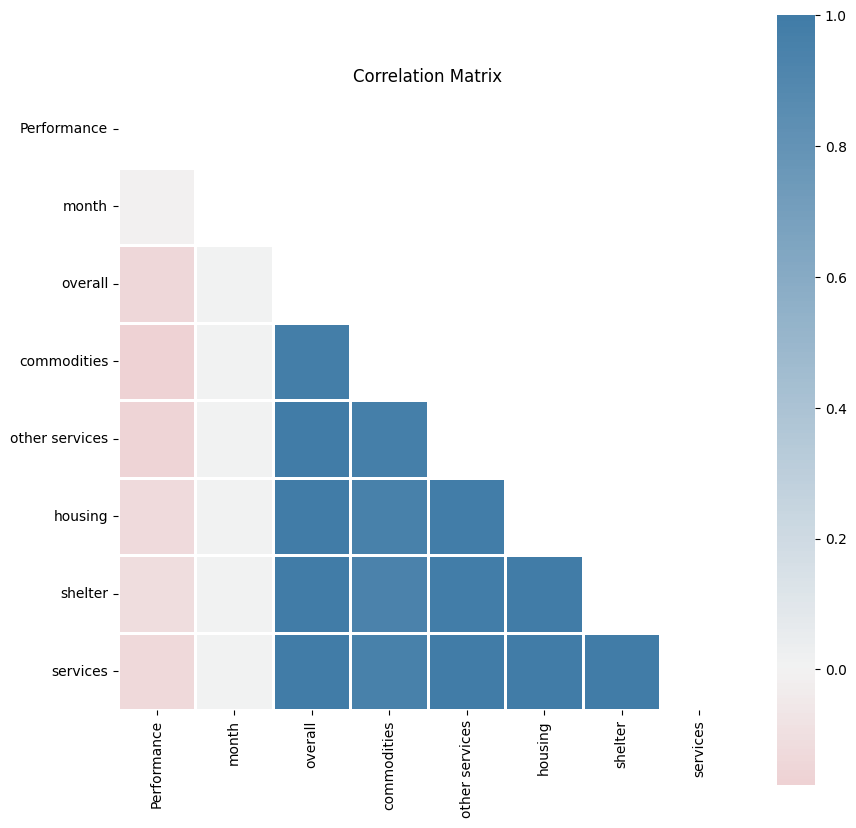

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,6,1033.797170,295.552694,-6.693858,-11.480408,179.771591,145.417290,216.852715,176.340852,213.717980,198.424321,3
1,2,1302.547920,368.875262,8.505979,30.306019,246.334177,153.522196,300.543828,213.572065,267.629110,283.066377,3
2,12,2343.894267,633.924277,-3.331472,-4.696680,228.706017,164.554574,339.276906,255.567682,299.457017,338.957019,3
3,11,1147.714718,276.533201,3.318407,-5.487560,167.247976,142.283822,227.665692,156.269070,181.531304,177.631030,3
4,7,947.328554,154.087083,-15.182679,-24.113226,167.000203,133.198307,215.505237,160.455607,176.647885,176.714531,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,1384.607052,585.623023,9.669808,4.165221,216.518092,181.309530,330.923790,222.011239,289.446190,268.329613,3
9996,9,379.453331,243.264397,2.039504,-8.767782,156.492866,179.397144,275.617858,160.743868,202.565498,233.241565,3
9997,10,529.804943,156.847867,-12.439822,-26.481663,157.204103,151.891981,206.061768,153.101652,154.400056,168.350324,3
9998,11,1121.597122,222.344131,-1.540796,-7.171694,206.912946,164.538988,277.238566,224.678131,247.355772,223.812018,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
samples.head()

,Performance,month,overall,commodities,other services,housing,shelter,services
0,0,6,179.771591,145.417290,216.852715,176.340852,213.717980,198.424321
1,1,2,246.334177,153.522196,300.543828,213.572065,267.629110,283.066377
2,0,12,228.706017,164.554574,339.276906,255.567682,299.457017,338.957019
3,0,11,167.247976,142.283822,227.665692,156.269070,181.531304,177.631030
4,0,7,167.000203,133.198307,215.505237,160.455607,176.647885,176.714531


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,8
Size in Memory,625.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.35,0.48,2,6498
month,int64,0,0,1,7,12,6.55,3.44,12,894
overall,float64,0,0,116.12,216.48,305.69,206.90,38.78,9999,2
commodities,float64,0,0,117.96,169.85,210.51,164.90,20.73,10000,1
other services,float64,0,0,154.41,292.22,423.37,291.50,62.18,10000,1
housing,float64,0,0,116.55,212.99,314.15,206.69,41.26,9999,2
shelter,float64,0,0,121.31,246.20,388.96,243.69,58.0047,10000,1
services,float64,0,0,135.39,254.29,418.18,248.60,63.52,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

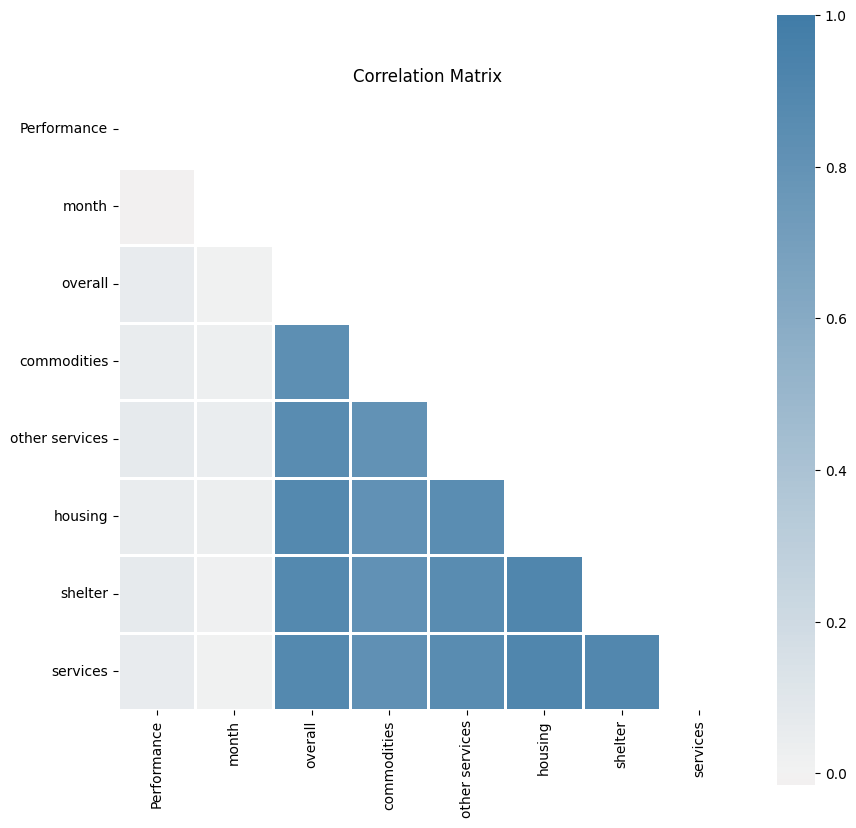

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6498, 1: 3502})
Counter({0: 6498, 1: 6498})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[   179.77159059,    145.41729033,    216.85271475, ...,
         37687.21057333,  34990.31372772,  42406.84506576],
       [   246.33417731,    153.52219623,    300.54382762, ...,
         57158.10160014,  60455.070638  ,  75756.80266834],
       [   228.70601686,    164.55457403,    339.2769064 , ...,
         76531.53551381,  86626.45953097, 101503.05767538],
       ...,
       [   176.23357419,    144.00312507,    230.07250881, ...,
         33397.64427676,  30988.61490945,  35944.31311774],
       [   244.24047364,    183.45514128,    360.77840475, ...,
         82223.07015905,  78295.13024093,  89657.93409382],
       [   226.23418046,    186.19630898,    265.87584342, ...,
         52419.89719847,  53190.87057515,  62962.74367969]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12996, 22)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(343, 22)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.637055,0.614772,0.726098,0.665045,0.609418,0.589556,0.700372,0.640204,0.507289,0.483607,0.357576,0.41115
1,DecisionTreeClassifier,0.624818,0.614474,0.663001,0.636638,0.616497,0.607647,0.640819,0.623792,0.536443,0.522727,0.418182,0.464646
2,RandomForestClassifier,0.737788,0.719867,0.768592,0.739832,0.698369,0.688544,0.715881,0.701946,0.451895,0.35443,0.169697,0.229508
3,AdaBoostClassifier,0.595496,0.585791,0.648677,0.615151,0.592182,0.578976,0.652605,0.61359,0.483965,0.461538,0.436364,0.448598
4,GradientBoostingClassifier,0.621894,0.605226,0.697313,0.647603,0.615266,0.597417,0.688586,0.639769,0.460641,0.439759,0.442424,0.441088
5,ExtraTreesClassifier,0.763489,0.749675,0.783215,0.761651,0.728224,0.720242,0.739454,0.729721,0.527697,0.523077,0.206061,0.295652
6,BaggingClassifier,0.674303,0.67938,0.650088,0.662088,0.657433,0.663392,0.628412,0.645428,0.469388,0.414141,0.248485,0.310606
7,SVC,0.590962,0.569457,0.739328,0.643063,0.598954,0.572981,0.752481,0.650577,0.51312,0.495146,0.618182,0.549865
8,GaussianNB,0.530239,0.529713,0.538784,0.53417,0.528163,0.523113,0.554591,0.538392,0.402332,0.380952,0.387879,0.384384


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.708526,0.691202,0.745658,0.717398


## Using data after 2000 (Best Model)

In [22]:
data = pd.read_csv('../data/S&P 500 Financials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
80,2000,1,2000-01-13,1449.68,298.109985,-1.473467,10.390668,OUTPERFORM,170.000,147.600,227.200,167.300,190.900,192.500,3
81,2000,2,2000-02-10,1416.83,280.170013,-2.032872,6.702977,OUTPERFORM,171.000,149.100,227.700,167.700,191.600,193.100,3
82,2000,3,2000-03-09,1401.69,255.740005,-2.531813,-2.404215,OUTPERFORM,170.900,148.500,228.100,167.900,191.900,193.500,3
83,2000,4,2000-04-13,1440.51,286.480011,-3.467247,10.734035,OUTPERFORM,171.200,148.500,228.700,168.300,192.400,194.000,3
84,2000,5,2000-05-11,1407.81,272.510010,-1.307432,10.180733,OUTPERFORM,172.200,149.600,229.200,169.200,193.100,194.900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,-7.184331,-10.749254,UNDERPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,-6.940799,-11.868717,UNDERPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,-1.171440,0.458468,OUTPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,3.749053,11.528212,OUTPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [23]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,1,1329.194998,242.446252,-0.843537,-4.165065,214.835168,181.826111,264.580402,213.072269,241.381241,249.486428,3
1,11,826.192862,179.225315,10.277763,37.379630,202.590335,143.783249,214.732848,186.003095,207.612234,216.126568,3
2,7,3576.951707,1292.241118,-7.891794,-7.070724,258.018593,191.653344,353.644089,250.307302,294.701310,323.230183,3
3,8,2314.468764,560.024087,-5.241098,-13.021993,246.802834,185.950261,356.171332,269.831694,297.148373,278.309118,3
4,9,2404.222129,614.473411,0.355429,-10.626224,248.626025,181.794785,349.106512,245.785168,284.950911,318.551699,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,783.106158,144.823822,-1.396815,-8.375456,188.878484,150.933027,231.644922,175.010055,215.485376,208.929716,3
9996,2,1147.226240,203.976687,-5.497646,-2.237466,210.220813,168.968041,247.907766,182.933438,249.060333,254.116122,3
9997,4,2394.417810,1113.000521,-7.423701,-11.128186,257.466865,201.354709,379.530737,263.394685,332.653806,338.674721,3
9998,1,1352.397609,240.594151,-3.173529,20.812665,181.657536,149.075761,244.368942,179.655316,214.079288,218.847643,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.665139,0.645402,0.727921,0.683411,0.648968,0.637121,0.699086,0.666667,0.596958,0.536,0.582609,0.558333
1,DecisionTreeClassifier,0.647114,0.637721,0.67351,0.653583,0.622091,0.618364,0.646214,0.631982,0.631179,0.591837,0.504348,0.544601
2,RandomForestClassifier,0.735704,0.725381,0.753332,0.736916,0.715503,0.718421,0.712794,0.715596,0.623574,0.575472,0.530435,0.552036
3,AdaBoostClassifier,0.653418,0.667611,0.61072,0.637683,0.648312,0.667396,0.597258,0.630382,0.631179,0.59,0.513043,0.548837
4,GradientBoostingClassifier,0.667842,0.67304,0.652521,0.662465,0.654212,0.664143,0.629896,0.646566,0.596958,0.541284,0.513043,0.526786
5,ExtraTreesClassifier,0.752751,0.741968,0.770054,0.752874,0.740413,0.739327,0.746084,0.74269,0.589354,0.537634,0.434783,0.480769
6,BaggingClassifier,0.69104,0.703921,0.652858,0.674774,0.687971,0.712299,0.635117,0.671498,0.574144,0.514286,0.469565,0.490909
7,SVC,0.655794,0.68227,0.583185,0.628753,0.650279,0.681499,0.569843,0.62069,0.604563,0.553398,0.495652,0.522936
8,GaussianNB,0.653663,0.673518,0.59646,0.63259,0.647657,0.670905,0.585509,0.625305,0.596958,0.541284,0.513043,0.526786


## Using data after 2010

In [25]:
data = pd.read_csv('../data/S&P 500 Financials 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
200,2010,1,2010-01-14,1148.46,238.649994,8.787618,-2.687168,UNDERPERFORM,217.281,174.321,307.253,216.042,247.997,259.970,3
201,2010,2,2010-02-11,1078.47,230.320007,1.716544,-2.128923,UNDERPERFORM,217.353,174.137,307.568,216.146,247.914,260.342,3
202,2010,3,2010-03-11,1150.24,252.570007,2.657837,1.315742,UNDERPERFORM,217.403,173.874,308.675,216.092,247.959,260.672,3
203,2010,4,2010-04-08,1186.44,265.380005,13.110628,11.899140,UNDERPERFORM,217.290,173.367,309.303,216.128,248.128,260.932,3
204,2010,5,2010-05-13,1157.44,264.690002,-0.285160,-1.437344,UNDERPERFORM,217.199,172.929,309.997,216.060,248.295,261.188,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,-7.184331,-10.749254,UNDERPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,-6.940799,-11.868717,UNDERPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,-1.171440,0.458468,OUTPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,3.749053,11.528212,OUTPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [26]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,2,1332.766372,212.123904,15.053151,-0.820875,231.201152,181.820853,326.777552,226.539736,248.490971,287.084038,3
1,7,1076.796560,488.410028,-19.644089,-13.665866,232.844709,191.637868,319.899163,231.968243,263.657220,273.664631,3
2,10,3572.144319,1333.046383,-11.594823,-10.508813,282.085438,221.748279,380.295604,301.332668,342.067837,352.819123,3
3,5,2255.098757,675.191114,-3.333265,-5.887770,237.281675,176.126652,344.654677,264.865825,295.362084,326.698458,3
4,12,1178.500526,247.015966,-7.469468,-14.424067,226.204735,189.022113,313.549834,209.066348,253.544543,279.876424,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7,902.538602,395.651343,-5.965330,-10.847466,229.318801,189.102144,319.911765,221.458909,255.256025,278.464464,3
9996,6,3487.333731,1489.003298,2.255988,6.544065,275.026453,210.908344,388.844897,286.094223,339.378273,363.436216,3
9997,12,3124.915208,713.207120,-8.603704,-4.929647,243.054911,186.128682,343.137200,253.243611,299.709966,310.429430,3
9998,10,1725.322347,396.590596,-13.238249,-10.493424,234.286341,189.480562,339.121522,234.398929,274.596369,299.718776,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.579423,0.581147,0.568826,0.574843,0.595248,0.598063,0.585771,0.591853,0.559441,0.431034,0.454545,0.442478
1,DecisionTreeClassifier,0.555754,0.55619,0.552784,0.554355,0.566733,0.567911,0.565217,0.566561,0.538462,0.424658,0.563636,0.484375
2,RandomForestClassifier,0.615768,0.623071,0.58626,0.604052,0.628515,0.635685,0.605534,0.620243,0.65035,0.54902,0.509091,0.528302
3,AdaBoostClassifier,0.628339,0.639278,0.589426,0.613172,0.639604,0.651839,0.602372,0.62613,0.629371,0.516129,0.581818,0.547009
4,GradientBoostingClassifier,0.633488,0.637547,0.61834,0.627728,0.644752,0.6458,0.644269,0.645034,0.601399,0.485294,0.6,0.536585
5,ExtraTreesClassifier,0.610319,0.617718,0.579717,0.598005,0.623366,0.631933,0.594466,0.612627,0.566434,0.438596,0.454545,0.446429
6,BaggingClassifier,0.596555,0.616324,0.512971,0.559603,0.59604,0.614808,0.518577,0.562607,0.573427,0.45,0.490909,0.469565
7,SVC,0.612891,0.641063,0.512971,0.569813,0.610297,0.64008,0.50751,0.566138,0.636364,0.52459,0.581818,0.551724
8,GaussianNB,0.599225,0.639341,0.455732,0.531987,0.594059,0.632743,0.452174,0.527432,0.636364,0.531915,0.454545,0.490196
